In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random
from torch.nn import functional as F

In [2]:
os.chdir("/home/atul/diffusion-based-environment-generator/generator")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/atul/diffusion-based-environment-generator/generator


In [3]:
from maze.grid_world_generator import generate_multiple_grid_worlds

generate_multiple_grid_worlds(1, 10)

./data/grid/


Generating Grid Worlds: 100%|██████████| 1/1 [00:00<00:00, 258.72it/s]


In [4]:
class GridWorldDataset(Dataset):
    def __init__(self, directory):
        # print(directory)
        self.files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # print(self.files[idx])
        grid = np.load(self.files[idx])
        return torch.tensor(grid, dtype=torch.int32)

In [ ]:
def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    # Below is ChatGPT   
    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([0, 0, 1])  # Source → Blue
    img[destination] = np.array([0, 1, 0])  # Destination → Green
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
dataset = GridWorldDataset("/home/atul/diffusion-based-environment-generator/generator/data/grid")

In [ ]:
def display_grid_text(grid):
    """
    Displays the grid world in text format.
    """
    height, width = grid.shape[1], grid.shape[2]
    char_grid = np.full((height, width), '-', dtype=str)
    
    wall = grid[:, :, 0] == 0
    source = grid[:, :, 1] == 1
    destination = grid[:, :, 2] == 1
    
    char_grid = np.full(wall.shape, '-', dtype=str)  # Default to empty space
    char_grid[wall] = '#'  # Walls
    char_grid[source] = 'S'  # Source
    char_grid[destination] = 'E'  # Destination
    
    print("\n".join("".join(row) for row in char_grid))

In [8]:
print(dataset[0].shape)

torch.Size([10, 10, 3])


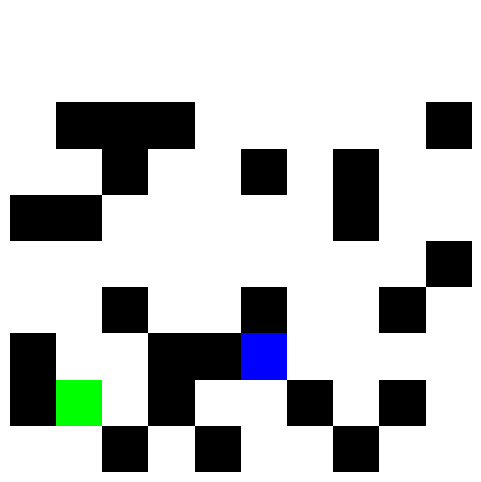

In [9]:
plot_grid_world(dataset[0])

In [10]:
display_grid_text(dataset[0])

----------
----------
-###-----#
--#--#-#--
##-----#--
---------#
--#--#--#-
#--##S----
#E-#--#-#-
--#-#--#--


In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [12]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/atul/diffusion-based-environment-generator/generator


In [14]:
import torch
from torch import nn
import torch.nn.functional as F

class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 10x10x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 5x5x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 3x3x128
            nn.ReLU(),
            nn.Conv2d(128, latent_dim * 2, kernel_size=3, padding=1)  # 3x3x(latent_dim * 2)
        )

        self.latent_dim = latent_dim

    def forward(self, x, noise):
        x = self.encoder(x)  # (B, latent_dim*2, 3, 3)
        
        mean, log_var = torch.chunk(x, 2, dim=1)  # Split into two parts
        log_var = torch.clamp(log_var, -10, 10)  
        var = log_var.exp()
        stdev = var.sqrt()

        z = mean + stdev * noise  # Reparameterization trick
        return mean, log_var, z
    

In [15]:
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 128, kernel_size=3, padding=1),  # 3x3x128
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 6x6
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 6x6x64
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 12x12
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 12x12x32
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # 12x12x3 (Extra padding)
        )

    def forward(self, z):
        # Forward pass through decoder
        x = self.decoder(z)  # Shape: (B, 3, 12, 12)

        # Crop to 10x10 (assuming output is 12x12)
        x = x[:, :, :10, :10]

        # Process channels for discrete output
        wall = torch.sigmoid(x[:, 0])  # Channel 1: Sigmoid for walls
        
        # Apply softmax over each pixel (across spatial dimensions) for source and destination
        source = F.softmax(x[:, 1], dim=1)  # Shape: (B, 10, 10)
        destination = F.softmax(x[:, 2], dim=1)  # Shape: (B, 10, 10)

        # Ensure a single position is max for source/destination
        source_idx = source.argmax(dim=1, keepdim=True)  # Shape: (B, 1, 10, 10)
        destination_idx = destination.argmax(dim=1, keepdim=True)  # Shape: (B, 1, 10, 10)

        # Create one-hot encoded source/destination
        source_one_hot = torch.zeros_like(source).scatter_(1, source_idx, 1)
        destination_one_hot = torch.zeros_like(destination).scatter_(1, destination_idx, 1)

        # Stack the channels to return the final output
        return torch.stack([wall, source_one_hot, destination_one_hot], dim=1)

In [16]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 30
LATENT_CHANNELS = 4

In [17]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Training dataset size: {len(dataset)}')

Training dataset size: 1


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

cuda


In [19]:
def vae_loss(x, x_hat, mean, log_var):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    
    kl_loss = 0.5 * (mean.pow(2) + log_var.exp() - log_var - 1).sum(dim=(1, 2, 3)).mean()
    
    return recon_loss + kl_loss

Training: 100%|██████████| 1/1 [00:00<00:00,  1.24batch/s]


Epoch [1/30], Train Loss: 47.3074


Training: 100%|██████████| 1/1 [00:00<00:00, 90.20batch/s]


Epoch [2/30], Train Loss: 47.0747


Training: 100%|██████████| 1/1 [00:00<00:00, 105.28batch/s]


Epoch [3/30], Train Loss: 46.8447


Training: 100%|██████████| 1/1 [00:00<00:00, 119.35batch/s]


Epoch [4/30], Train Loss: 46.8449


Training: 100%|██████████| 1/1 [00:00<00:00, 95.52batch/s]


Epoch [5/30], Train Loss: 44.4814


Training: 100%|██████████| 1/1 [00:00<00:00, 133.26batch/s]


Epoch [6/30], Train Loss: 46.3229


Training: 100%|██████████| 1/1 [00:00<00:00, 98.37batch/s]


Epoch [7/30], Train Loss: 45.7845


Training: 100%|██████████| 1/1 [00:00<00:00, 111.36batch/s]


Epoch [8/30], Train Loss: 46.2394


Training: 100%|██████████| 1/1 [00:00<00:00, 103.05batch/s]


Epoch [9/30], Train Loss: 45.2767


Training: 100%|██████████| 1/1 [00:00<00:00, 124.39batch/s]


Epoch [10/30], Train Loss: 43.3126


Training: 100%|██████████| 1/1 [00:00<00:00, 108.84batch/s]


Epoch [11/30], Train Loss: 42.8303


Training: 100%|██████████| 1/1 [00:00<00:00, 107.47batch/s]


Epoch [12/30], Train Loss: 44.6050


Training: 100%|██████████| 1/1 [00:00<00:00, 145.12batch/s]


Epoch [13/30], Train Loss: 42.1824


Training: 100%|██████████| 1/1 [00:00<00:00, 112.27batch/s]


Epoch [14/30], Train Loss: 42.0628


Training: 100%|██████████| 1/1 [00:00<00:00, 111.87batch/s]


Epoch [15/30], Train Loss: 42.3011


Training: 100%|██████████| 1/1 [00:00<00:00, 63.15batch/s]


Epoch [16/30], Train Loss: 43.5701


Training: 100%|██████████| 1/1 [00:00<00:00, 100.84batch/s]


Epoch [17/30], Train Loss: 43.3046


Training: 100%|██████████| 1/1 [00:00<00:00, 96.47batch/s]


Epoch [18/30], Train Loss: 42.5718


Training: 100%|██████████| 1/1 [00:00<00:00, 76.58batch/s]


Epoch [19/30], Train Loss: 42.9245


Training: 100%|██████████| 1/1 [00:00<00:00, 106.21batch/s]


Epoch [20/30], Train Loss: 41.9628


Training: 100%|██████████| 1/1 [00:00<00:00, 81.97batch/s]


Epoch [21/30], Train Loss: 41.9112


Training: 100%|██████████| 1/1 [00:00<00:00, 91.45batch/s]


Epoch [22/30], Train Loss: 41.8012


Training: 100%|██████████| 1/1 [00:00<00:00, 111.38batch/s]


Epoch [23/30], Train Loss: 42.1078


Training: 100%|██████████| 1/1 [00:00<00:00, 88.85batch/s]


Epoch [24/30], Train Loss: 37.8654


Training: 100%|██████████| 1/1 [00:00<00:00, 98.23batch/s]


Epoch [25/30], Train Loss: 42.0491


Training: 100%|██████████| 1/1 [00:00<00:00, 97.56batch/s]


Epoch [26/30], Train Loss: 42.3250


Training: 100%|██████████| 1/1 [00:00<00:00, 113.93batch/s]


Epoch [27/30], Train Loss: 41.1079


Training: 100%|██████████| 1/1 [00:00<00:00, 91.28batch/s]


Epoch [28/30], Train Loss: 39.1281


Training: 100%|██████████| 1/1 [00:00<00:00, 103.76batch/s]


Epoch [29/30], Train Loss: 41.1380


Training: 100%|██████████| 1/1 [00:00<00:00, 100.20batch/s]


Epoch [30/30], Train Loss: 41.0767


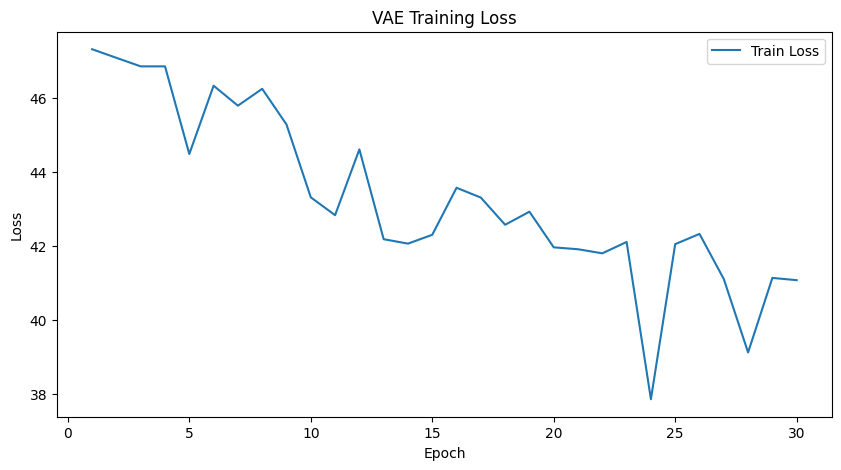

In [20]:
from tqdm import tqdm

train_losses = []
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(tqdm(dataloader, desc="Training", unit="batch")):
        x = x.to(torch.float32).to(device).permute(0, 3, 1, 2)
        batch_size = x.size(0)
        
        noise = torch.randn(batch_size, LATENT_CHANNELS, 3, 3).to(device)
        
        mean, log_var, z = encoder(x, noise)
        x_hat = decoder(z)
        
        loss = vae_loss(x, x_hat, mean, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        
    train_loss = train_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

In [21]:
def visualize_grid_world(grid):
    """
    Converts a 3-channel grid world into an RGB image for visualization.
    - First channel: Wall (0 or 1)
    - Second channel: Source (1 if source)
    - Third channel: Destination (1 if destination)
    """
    # Extract channels
    wall = grid[:, :, 0] == 0
    source = grid[:, :, 1] == 1
    destination = grid[:, :, 2] == 1
    
    # Create an RGB image with a white background (1, 1, 1)
    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    
    # Set walls to black (0, 0, 0)
    img[wall] = np.array([0, 0, 0])
    
    # Set source to blue (0, 0, 1)
    img[source] = np.array([0, 0, 1])
    
    # Set destination to green (0, 1, 0)
    img[destination] = np.array([0, 1, 0])
    
    return img


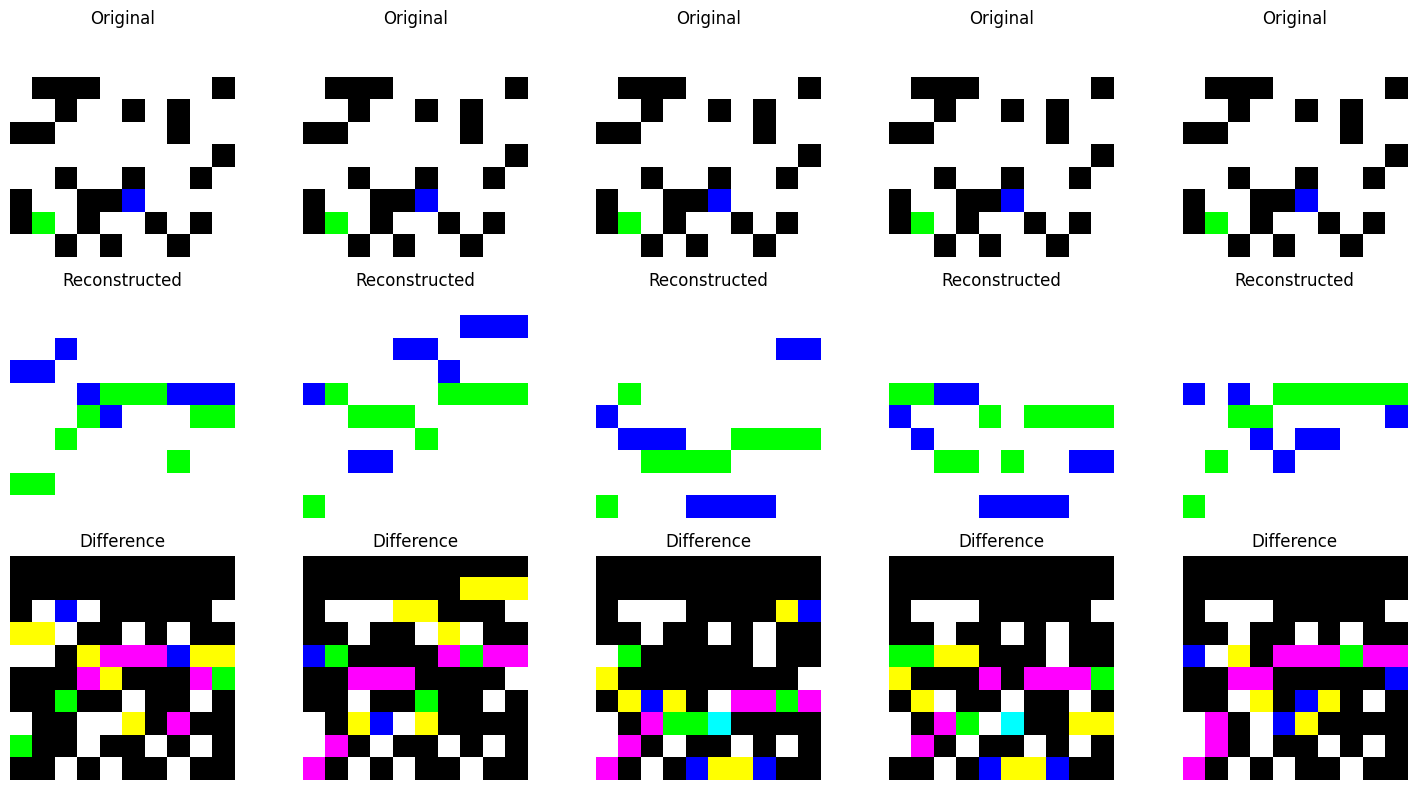

In [ ]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))  # Create 3x5 grid of subplots
    
    for i in range(1):
        idx = np.random.randint(len(dataset))
        img = dataset[idx]  # Ignore the path length label for reconstruction
        img = img.unsqueeze(0).to(torch.float32).to(device).permute(0, 3, 1, 2)
        
        # Generate noise for reparameterization trick
        noise = torch.randn(1, LATENT_CHANNELS, 3, 3).to(device)
        
        # Encoder and Decoder
        _, _, z = encoder(img, noise)
        reconstructed = decoder(z).cpu().squeeze(0)
        
        original = img.cpu().squeeze(0)
        
        # Convert the grid world to RGB for visualization
        original_rgb = visualize_grid_world(original.permute(1, 2, 0).numpy())
        reconstructed_rgb = visualize_grid_world(reconstructed.permute(1, 2, 0).numpy())
        
        # Compute the absolute difference between original and reconstructed
        difference = np.abs(original_rgb - reconstructed_rgb)
        
        # Original Image
        axes[0, i].imshow(original_rgb)
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        # Reconstructed Image
        axes[1, i].imshow(reconstructed_rgb)
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
        
        # Difference Image (showing difference in RGB space)
        axes[2, i].imshow(difference)
        axes[2, i].axis('off')
        axes[2, i].set_title('Difference')
    
    plt.tight_layout()
    plt.show()